# Tarea realizada por Jesús Martínez Leal y Slanc (Best Beidou Main, sin MédulaR5)
Última edición: 17/02/2024

# Reconocimiento de caras

El objetivo de este proyecto es el de encontrar las caras del dataset de train que más se parecen a las del dataset de test. Para ello utilizaremos PCA y KPCA.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
import timeit

from utils_func import get_faces, get_person_num, show_sample_faces, split_train_test,get_stats

- Fijamos el random_state en todo el documento.

In [2]:
rs = 0

### Cargamos el dataset

In [3]:
faces = get_faces(zipfile_path="./data/Grp13Dataset.zip")

In [4]:
faceshape = list(faces.values())[0].shape
print("Face image shape:", faceshape)

Face image shape: (80, 70)


In [5]:
classes = set(filename.split("/")[0] for filename in faces.keys())
print("Number of classes:", len(classes))
print("Number of images:", len(faces))

Number of classes: 41
Number of images: 410


In [6]:
facematrix = []
facelabel = []

training_set, testing_set = split_train_test(zipfilepath="./data/Grp13Dataset.zip")

Construye la matriz de datos como una matriz en la que cada fila se corresponde con una imagen y cada columna con los píxeles de las imágenes en 1D. Construye también el vector facelabel. 

In [7]:
# Construir las matrices "facematrix" y "facelabel"

start = timeit.default_timer()

for person, images in training_set.items(): # accedo a llaves, valores del diccionario de training
    
    image_flat = images.flatten() 
    facematrix.append(image_flat)
    facelabel.append(get_person_num(person))

    
stop = timeit.default_timer()
print("Time:", stop - start)

Time: 0.003387100005056709


Revisando `utils_func.py`, es fácil ver que la función `split_train_test()` hace que las imágenes 0 y 1 de cada persona vayan al conjunto de testing.

# PCA 

Realiza la PCA. Haz pruebas con diferente número de componentes comprobando el error en el acierto.

No hace falta quitar la media de las imágenes, ya que `PCA()` de sklearn lo hace por nosotros. Esto se ve en el enlace: https://github.com/scikit-learn/scikit-learn/blob/6eff1757e/sklearn/decomposition/_pca.py#L431.

In [8]:
facematrix_np = np.array(facematrix)

mean_image = np.mean(facematrix_np, axis = 0) # se pone axis = 0 puesto que así se hace la media de cada columna

#facematrix_centered = facematrix_np - mean_image
facematrix_centered = facematrix_np

Se representa a continuación la cara media.

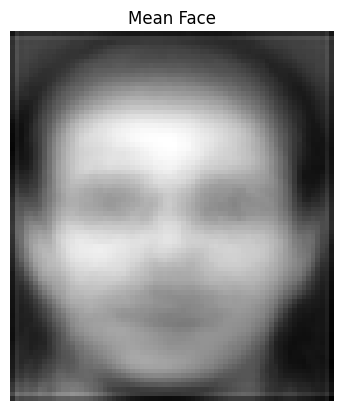

In [9]:
mean_face = mean_image.reshape(faceshape)


plt.imshow(mean_face, cmap = 'gray')
plt.title('Mean Face')
plt.axis('off')
plt.show()

Representa las primeras "eigenfaces" en escala de grises utilizando un subplot. 

Antes de representarlas, evaluamos cuántas componentes debe tener nuestro modelo de PCA para reducir dimensionalidad manteniendo una cantidad de información razonable sobre nuestros datos.

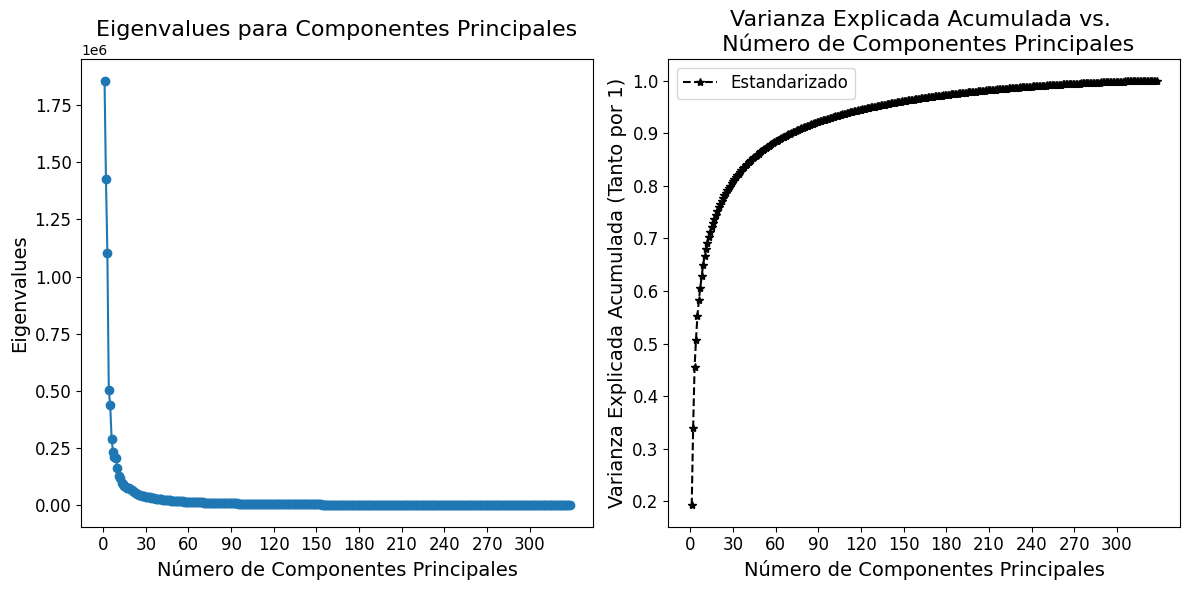

In [10]:
pca = PCA(random_state = rs)
pca.fit(facematrix_centered)


eigenvalues = pca.explained_variance_

# Varianza explicada acumulada
cumulative_variance_explained = np.cumsum(pca.explained_variance_ratio_)
num_components = np.arange(1, len(cumulative_variance_explained) + 1)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Gráfico de autovalores

axs[0].plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o')
axs[0].set_xlabel('Número de Componentes Principales', fontsize=14)
axs[0].set_ylabel('Eigenvalues', fontsize=14)
axs[0].set_title('Eigenvalues para Componentes Principales', fontsize=16)
axs[0].tick_params(axis='both', which='major', labelsize=12)  
axs[0].set_xticks(np.arange(0, len(eigenvalues) + 1, 30))  

# Gráfico de varianza explicada acumulada

axs[1].plot(num_components, cumulative_variance_explained, linestyle='--', marker='*', color='black', label='Estandarizado')
axs[1].set_xlabel('Número de Componentes Principales', fontsize=14)
axs[1].set_ylabel('Varianza Explicada Acumulada (Tanto por 1)', fontsize=14)
axs[1].legend(fontsize=12)
axs[1].set_title('Varianza Explicada Acumulada vs. \n Número de Componentes Principales', fontsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=12)  
axs[1].set_xticks(np.arange(0, len(eigenvalues) + 1, 30)) 

plt.tight_layout()


plt.show()


In [11]:
num_components = np.argmax(cumulative_variance_explained >= 0.95) + 1
print(f"Se selecciona un total de {num_components} componentes principales.")

Se selecciona un total de 129 componentes principales.


- Obtención de las `eigenfaces`.

In [12]:
pca = PCA(n_components = num_components, random_state = rs, svd_solver = 'full') # modelo de PCA de reducción de dimensionalidad

pca.fit(facematrix_centered)

eigenfaces = pca.components_ #.reshape(-1, *faceshape): están ordenados en orden decreciente de explained_variance_

Lo que devuelve `.components_` es un número de vectores igual a `n_components` en el espacio original que explican la mayor varianza de nuestros datos. 

Como resultado, ya que estamos cogiendo un número inferior a la dimensionalidad del espacio original, estamos reduciendo dimensionalidad.

- Representación de las `eigenfaces`.

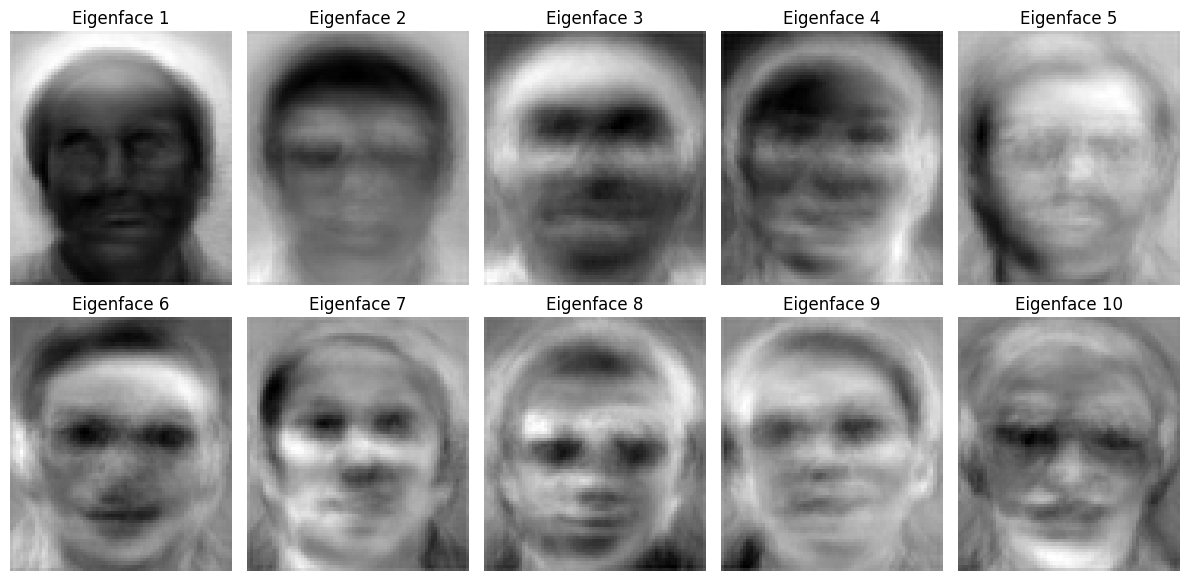

In [13]:
num_eigenfaces = 10 # número a mostrar en el plot

plt.figure(figsize=(12, 6))
for i in range(num_eigenfaces):
    eigenface = pca.components_[i].reshape(faceshape)  # Reshape del autovector a la forma de la imagen
    plt.subplot(2, 5, i + 1)
    plt.imshow(eigenface, cmap = 'gray')
    plt.title('Eigenface {}'.format(i + 1))
    plt.axis('off')

plt.tight_layout()
plt.show()

Completar la función *get_best_match()* para que compare la PCA de train con la PCA de las imágenes de test. Calcula la distancia euclídea entre ambas con la función *np.linalg.norm*.

In [15]:
def get_best_match(filename, pca, plot = True, text = True):
    query = faces[filename].reshape(1, -1)
    
    pca_train = pca.transform(facematrix_centered)
    pca_query = pca.transform(query) # calculamos la proyección al espacio de menor dimensionalidad para una cara en concreto
    
    euclidean_distance = np.linalg.norm(pca_query - pca_train, axis = 1) # vector con distancias; en facelabel está el orden de las personas de pca_train
    
    best_match = np.argmin(euclidean_distance) 
    
    if text:
        print("Best match %s with Euclidean distance %f" %  (facelabel[best_match], euclidean_distance[best_match]))
    
    person_num, img_num = get_person_num(filename=filename)
    
    if plot:
        fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 6))

        axes[0].imshow(query.reshape(faceshape), cmap="gray")
        axes[0].set_title("Query - Person " + str(person_num))
        axes[1].imshow(facematrix[best_match].reshape(faceshape), cmap="gray")
        axes[1].set_title("Best match - Person " + str((best_match//8) + 1)) # el 8 ese creo que es porque hay 8 fotos de cada persona en train
        plt.show()
    
    # uncomment the above line to see individual results of testing faces
    return (((best_match // 8) + 1), person_num) # predicha y el verdadero, básicamente

Llama a la función *get_best_match* y contabiliza las predicciones totales, las correctas y las falsas.

In [16]:
stop = timeit.default_timer()

correct_pred = 0
wrong_pred = 0
total_pred = 0

for key, val in testing_set.items(): 

    total_pred += 1
    
    predicted, actual = get_best_match(filename = key, pca = pca, plot = False)

    if predicted == actual:
        correct_pred += 1
    else:
        wrong_pred += 1

Best match (1, 5) with Euclidean distance 2321.855365
Best match (1, 7) with Euclidean distance 2189.345049
Best match (2, 3) with Euclidean distance 1255.454395
Best match (2, 8) with Euclidean distance 1124.678441
Best match (3, 3) with Euclidean distance 1614.600039
Best match (3, 9) with Euclidean distance 967.222270
Best match (4, 8) with Euclidean distance 1258.484554
Best match (4, 5) with Euclidean distance 1274.307253
Best match (5, 4) with Euclidean distance 593.723678
Best match (40, 5) with Euclidean distance 1576.954557
Best match (6, 3) with Euclidean distance 859.562540
Best match (6, 4) with Euclidean distance 655.674068
Best match (7, 3) with Euclidean distance 1244.048116
Best match (7, 5) with Euclidean distance 1538.583910
Best match (8, 2) with Euclidean distance 966.006730
Best match (8, 3) with Euclidean distance 1250.770329
Best match (9, 3) with Euclidean distance 936.076230
Best match (9, 5) with Euclidean distance 1584.364260
Best match (38, 4) with Euclidean

In [17]:
Correct_Predic, Wrong_Predic, Accuracy = get_stats(correct_pred,wrong_pred,total_pred)
print(f"Correct prediction: ",Correct_Predic)
print(f"Wrong prediction: ",Wrong_Predic)

print(f"Accuracy: ",Accuracy,"%")
print(f"Time Taken: ",round(stop-start,3),"s")

Correct prediction:  0.963
Wrong prediction:  0.037
Accuracy:  96.341 %
Time Taken:  2.669 s


In [18]:
def pca_accuracy_plot(facematrix_centered, faceshape, step = 3, num_components=50, rs=0):
    
    accuracies = {}
    
    for n in range(1, num_components + 1, step):
        
        pca_bucle = PCA(n_components=n, random_state=rs, svd_solver='full')
        pca_bucle.fit(facematrix_centered)

        correct_pred = 0
        wrong_pred = 0
        total_pred = 0

        for key, val in testing_set.items(): 
            total_pred += 1

            predicted, actual = get_best_match(filename=key, pca = pca_bucle, plot=False, text = False)

            if predicted == actual:
                correct_pred += 1
            else:
                wrong_pred += 1

        accuracies[n] = correct_pred / total_pred
    
    plt.plot(list(accuracies.keys()), list(accuracies.values()), marker='o')
    plt.title('Accuracy vs Number of Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()
    
    return accuracies

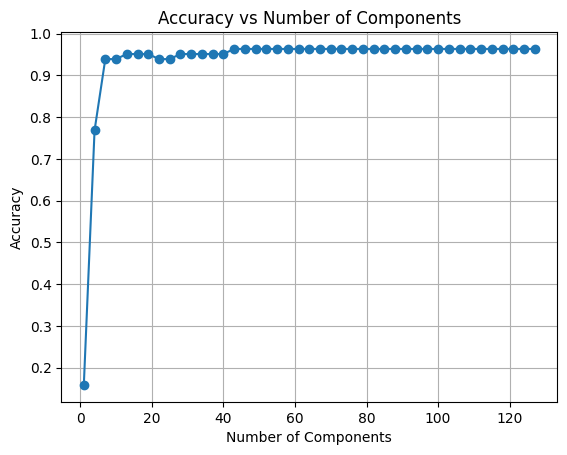

In [19]:
accuracies = pca_accuracy_plot(facematrix_centered, faceshape, step = 3, num_components=num_components, rs=0)

Como era de esperar, vemos un aumento creciente monótono en la `accuracy` hasta que llega al máximo y se queda estable.

# KPCA

Intenta aplicar el mismo procedimiento con KPCA (kernel lineal). Tendrás que hacer algunas traspuestas para conseguirlo.

- Entrenamiento del modelo de KPCA.

In [20]:
# KPCA (Kernel PCA)
kpca = KernelPCA(kernel = "linear", fit_inverse_transform = True, random_state = rs, n_components = 10)
kpca.fit(facematrix_centered)

KernelPCA(fit_inverse_transform=True, n_components=10, random_state=0)

Con `KPCA()` no existe un método para mostrar las componentes en el espacio original como hacíamos con `PCA()`, por lo que no se puede representar las `eigenfaces` como tal.

In [22]:
def get_best_match_kpca(filename, kpca, plot = True, text = False):
    
    query = faces[filename].reshape(1, -1)
    
    kpca_train = kpca.transform(facematrix_centered)
    kpca_query = kpca.transform(query)  # Transformar la imagen de consulta al espacio de características de KPCA

    euclidean_distance = np.linalg.norm(kpca_query - kpca_train, axis=1)

    best_match = np.argmin(euclidean_distance)

    print("Best match %s with Euclidean distance %f" % (facelabel[best_match], euclidean_distance[best_match]))

    person_num, img_num = get_person_num(filename=filename)

    if plot:
        fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 6))

        axes[0].imshow(query.reshape(faceshape), cmap="gray")
        axes[0].set_title("Query - Person " + str(person_num))
        axes[1].imshow(facematrix[best_match].reshape(faceshape), cmap="gray")
        axes[1].set_title("Best match - Person " + str((best_match // 8) + 1))
        plt.show()

    return (((best_match // 8) + 1), person_num)

In [23]:
# Evaluación de KPCA
correct_pred_kpca = 0
wrong_pred_kpca = 0
total_pred_kpca = 0

for key, val in testing_set.items():
    total_pred_kpca += 1

    predicted_kpca, actual_kpca = get_best_match_kpca(filename=key, kpca = kpca, plot=False, text = False)

    if predicted_kpca == actual_kpca:
        correct_pred_kpca += 1
    else:
        wrong_pred_kpca += 1

Best match (1, 8) with Euclidean distance 1268.591423
Best match (16, 3) with Euclidean distance 1033.632046
Best match (2, 3) with Euclidean distance 549.045465
Best match (2, 8) with Euclidean distance 469.085274
Best match (3, 3) with Euclidean distance 703.517597
Best match (3, 9) with Euclidean distance 406.062563
Best match (4, 8) with Euclidean distance 661.204535
Best match (4, 5) with Euclidean distance 538.245654
Best match (5, 4) with Euclidean distance 243.426977
Best match (18, 6) with Euclidean distance 897.973359
Best match (6, 3) with Euclidean distance 287.961403
Best match (6, 4) with Euclidean distance 253.593546
Best match (7, 9) with Euclidean distance 477.591750
Best match (7, 5) with Euclidean distance 689.865874
Best match (8, 2) with Euclidean distance 467.494483
Best match (8, 3) with Euclidean distance 419.972197
Best match (9, 3) with Euclidean distance 359.076029
Best match (9, 5) with Euclidean distance 573.144502
Best match (38, 4) with Euclidean distance

In [24]:
Correct_Predic_KPCA, Wrong_Predic_KPCA, Accuracy_KPCA = get_stats(correct_pred_kpca, wrong_pred_kpca, total_pred_kpca)
print(f"Correct prediction with KPCA: ", Correct_Predic_KPCA)
print(f"Wrong prediction with KPCA: ", Wrong_Predic_KPCA)
print(f"Accuracy with KPCA: ", Accuracy_KPCA, "%")

Correct prediction with KPCA:  0.939
Wrong prediction with KPCA:  0.061
Accuracy with KPCA:  93.902 %
